In [1]:
import cv2
import numpy as np
import os
import glob

__Read the files and label them__

In [71]:
file = open('labels.txt','w')

In [72]:
for filename in glob.iglob('vehicles/**/*.png' , recursive = True):
    file.write(filename+"\t"+"1\n")   

In [73]:
for filename in glob.iglob('non-vehicles/**/*.png' , recursive = True):
    file.write(filename+"\t"+"0\n")

In [74]:
file.close()

__Make a dataframe__

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('labels.txt', sep='\t', header=None)

In [4]:
df.columns =  ["Image", "Label"]

In [5]:
df = df.sample(frac=1)
df = df.sample(frac=1)
df = df.sample(frac=1)

__Split the dataset into training and testing__

In [6]:
msk = np.random.rand(len(df)) < 0.8

In [7]:
train = df[msk]
train = train.reset_index()

In [8]:
test = df[~msk]
test = test.reset_index()

In [9]:
print("Testing size =  " + str(len(test)))
print("Training size = " + str(len(train)))

Testing size =  3496
Training size = 14264


__Compute the features__

In [198]:
bin_n = 16 # Number of bins
def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    # quantizing binvalues in (0...16)
    bins = np.int32(bin_n*ang/(2*np.pi))

    # Divide to 4 sub-squares
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)
    return hist

__Compute the patches from the image__

In [199]:
from sklearn.feature_extraction import image

In [200]:
img = cv2.imread(train["Image"][1])
patches = image.extract_patches_2d(img, (32,32), random_state=1, max_patches=30)
print(img.shape)

(64, 64, 3)


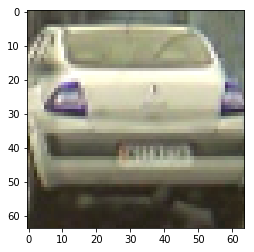

In [166]:
plt.imshow(img)

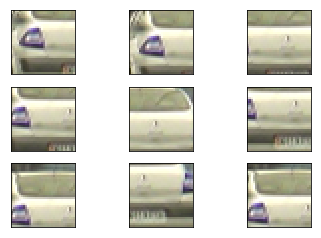

In [167]:
images = patches
for i in range(9):
    plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

In [204]:
list_features = []
i = 0
for image_path in train['Image']:
#     print (image_path)
    i = i + 1
    img  = cv2.imread(image_path)
    patches = image.extract_patches_2d(img, (32,32), random_state=1, max_patches=3)
    print('Downloading File FooFile.txt [%d%%]\r'%i, end="")
    for patch in patches:
        x = hog(patch)
        list_features.append((image_path, x))

__Knn to form clusters__

In [205]:
descriptors = list_features[0][1]
count = 0
for image_path, descriptor in list_features[1:]:
    count = count + 1
    print('Downloading File FooFile.txt [%d%%]\r'%count, end="")
    descriptors = np.vstack((descriptors, descriptor))

In [206]:
from scipy.cluster.vq import *
k = 20
voc, variance = kmeans(descriptors, k, 1) 

In [207]:
im_features = np.zeros((len(train["Image"]), k), "float32")
for i in range(len(train["Image"])):
    words, distance = vq(np.asmatrix(list_features[i][1]),voc)
    for w in words:
        im_features[i][w] += 1

In [213]:
import pickle
pickle.dump( im_features, open( "save.p", "wb" ) )

In [209]:
from sklearn.preprocessing import StandardScaler

In [210]:
# Scaling the words
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [215]:
im_features[0]
#Histogram equalization

array([-0.14880218, -0.16633102, -0.13757803, -0.62471843, -0.40159395,
       -0.10652165, -0.15626049, -0.11336143, -0.16522051, -0.10884062,
       -0.21316342, -0.1488024 , -0.14355075, -0.13968778, -0.21098495,
       -0.24163769, -0.26365504,  3.55826426, -0.15002039, -0.26316229], dtype=float32)

__Testing the model__

In [216]:
list_features_test = []
i = 0
for image_path in test['Image']:
#     print (image_path)
    i = i + 1
    img  = cv2.imread(image_path)
    patches = image.extract_patches_2d(img, (32,32), random_state=1, max_patches=3)
    print('Downloading File FooFile.txt [%d%%]\r'%i, end="")
    for patch in patches:
        x = hog(patch)
        list_features_test.append((image_path, x))

In [218]:
descriptors_test = []
descriptors_test = list_features_test[0][1]
count = 0
for image_path, descriptor in list_features_test[1:]:
    count = count + 1
    print('Downloading File FooFile.txt [%d%%]\r'%count, end="")
    descriptors_test = np.vstack((descriptors_test, descriptor))

In [219]:
from scipy.cluster.vq import *
k = 20
voc, variance = kmeans(descriptors_test, k, 1) 

In [220]:
test_features = np.zeros((len(test["Image"]), k), "float32")
for i in range(len(test["Image"])):
    words, distance = vq(np.asmatrix(list_features_test[i][1]),voc)
    for w in words:
        im_features[i][w] += 1

In [221]:
from sklearn.preprocessing import StandardScaler
# Scaling the words
stdSlr = StandardScaler().fit(test_features)
test_features = stdSlr.transform(test_features)

In [261]:
labels_train = train['Label']
labels_train = labels_train.values

In [262]:
labels_test = test['Label']
labels_test = labels_test.values

In [263]:
im_features.shape

(14264, 20)

In [264]:
test_features.shape

(3496, 20)

In [265]:
from sklearn.neighbors import KNeighborsClassifier

In [266]:
neigh = KNeighborsClassifier(n_neighbors=30)

In [267]:
neigh.fit(im_features, labels_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [268]:
prediction = neigh.predict(test_features)

In [270]:
from sklearn.metrics import accuracy_score

In [271]:
accuracy_score(labels_test, prediction)

0.49685354691075517